In [1]:
import scvelo as scv
import os 
from pathlib import Path
import numpy as np 
import pandas as pd 


In [2]:
notebook_dir = os.getcwd()
notebook_dir

'/Users/omercagatay/Desktop/Thesis/git_repo/SALMON/notebooks/data simulation'

In [3]:
Path(notebook_dir).parents[3]

PosixPath('/Users/omercagatay/Desktop/Thesis')

In [4]:
os.chdir(Path(notebook_dir).parents[3])

In [ ]:
import sys  
sys.path.insert(1,'/Users/omercagatay/Desktop/Thesis/git_repo/SALMON')


# Rna Velocity Modelling 

## unspliced mRNA 

 - Consider the first order differential equation $$\frac{du(t)}{dt} =\alpha -\beta u(t).$$
With the inital condition $u(0)=u_0$, it has the analytical solution:<br>
 $$u(t)=u_0 e^{-\beta t}+\frac{\alpha}{\beta}(1-e^{-\beta t}),$$
 where $\alpha$ is the pre-mRNA transcription parameter, $\beta $ is the change rate from unspliced to spliced mRNA.



In [5]:
# function returns the analytical solution value for given tau, u0, alpha, beta for unspliced mRNA.
def unspliced(tau, u0, alpha, beta):
    """TODO."""
    expu = np.exp(-beta * tau)
    return u0 * expu + alpha / beta * (1 - expu)

In [6]:
def spliced_nucleus(tau, sn0, alpha, nu, beta, u0):
    term1 = sn0 * np.exp(-nu* tau)
    term2 = (alpha / nu) * (1 - np.exp(-nu * tau))
    term3 = (alpha - beta * u0) / (nu - beta) * (np.exp(-beta * tau) - np.exp(-nu * tau))
    
    return term1 + term2 + term3

In [7]:
def spliced_cyto(tau, alpha, beta, gamma, nu, u0, sn0, sc0):
    
    exp_beta = np.exp(-beta * tau)
    exp_gamma = np.exp(-gamma * tau)
    exp_nu = np.exp(-nu * tau)
    
    term1 = (alpha / beta) * (1 - exp_beta) + u0 * exp_beta
    term1 *= nu * beta / ((nu - beta) * (gamma - beta))
    
    term2 = (alpha / nu) * (1 - exp_nu) + u0 * exp_nu
    term2 *= 1 / ((gamma - nu) * (nu - beta))
    
    term3 = (alpha / nu) * (1 - exp_nu) + u0 * exp_nu
    term3 *= 1 / ((gamma - nu) * (nu - beta))
    
    term4 = (nu / (gamma - nu)) * (exp_nu - exp_gamma) * sn0
    term5 = exp_gamma * sc0
    
    result = term1 - term2 + term3 + term4 + term5
    
    return result


## spliced mRNA

Spliced mRNA change over time can be expressed by the differential equation;
$$\frac{ds}{dt}=\delta u-\gamma \mathrm{s}.$$

With the initial condition $s(0)=s_0$ the analytical solution is given by: 

$$s(t)=s_0 e^{-\gamma t}+\frac{\delta \alpha}{\beta \gamma}\left(1-e^{-\gamma t}\right)+\frac{\delta}{\beta} \frac{\alpha-\beta u_0}{\gamma-\beta}\left(e^{-\gamma t}-e^{-\beta t}\right)$$


- In the simulation $\gamma$ and $\delta$ taken the same. So the solution is given by the equation:

$$s(t)=s_0 e^{-\gamma t}+\frac{\alpha}{\gamma}\left(1-e^{-\gamma t}\right)+\frac{\alpha-\beta u_0}{\gamma-\beta}\left(e^{-\gamma t}-e^{-\beta t}\right)$$

# Vectorize Function 

In [8]:
import warnings
def vectorize(t, t_, alpha, beta, nu, gamma=None, alpha_=0, u0=0, sn0=0, sc0=0, sorted=False):
    
    """
    Vectorizes the parameters for mRNA splicing kinetics simulation based on the given time points.

    This function computes the vectorized values of the parameters `tau`, `alpha`, `u0`, and `s0`
    for a set of time points `t` and a threshold time `t_`.

    Parameters
    ----------
    t : array_like
        Array of time points at which to compute the parameters.
    t_ : float
        Threshold time point which separates two different regimes in the simulation.
    alpha : array_like or float
        Transcription rate parameter. This can be a scalar or an array of the same length as `t`.
    beta : array_like or float
        Splicing rate parameter. This can be a scalar or an array of the same length as `t`.
    gamma : array_like or float, optional
        Degradation rate parameter. Defaults to `beta / 2` if not provided.
    alpha_ : float, optional
        Secondary transcription rate parameter used after the threshold time `t_`. Defaults to 0.
    u0 : float, optional
        Initial unspliced mRNA level. Defaults to 0.
    s0 : float, optional
        Initial spliced mRNA level. Defaults to 0.
    sorted : bool, optional
        If True, the resulting arrays are sorted by time `t`. Defaults to False.

    Returns

    tuple of numpy.ndarray
        Tuple containing the following elements:
        - `tau` : numpy.ndarray
            Vectorized time points after applying the threshold `t_`.
        - `alpha` : numpy.ndarray
            Vectorized transcription rate parameter.
        - `u0` : numpy.ndarray
            Vectorized initial unspliced mRNA levels.
        - `s0` : numpy.ndarray
            Vectorized initial spliced mRNA levels.
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        o = np.array(t < t_, dtype=int)
    tau = t * o + (t - t_) * (1 - o)

    u0_ = unspliced(t_, u0, alpha, beta)

    sn0_ = spliced_nucleus(t_, sn0, alpha, nu, beta, u0)

    sc0_ = spliced_cyto(t_, alpha, beta, gamma, nu, u0, sn0, sc0)

    # vectorize u0, s0 and alpha
    u0 = u0 * o + u0_ * (1 - o)
    sn0 = sn0 * o + sn0_ * (1 - o)
    sc0 = sc0 * o + sc0_ * (1 - o)
    alpha = alpha * o + alpha_ * (1 - o)

    if sorted:
        idx = np.argsort(t)
        tau, alpha, u0, s0 = tau[idx], alpha[idx], u0[idx], s0[idx]
    return tau, alpha, u0, sn0, sc0

# Simulate 

In [ ]:
from anndata import AnnData

In [68]:
def simulation_3ode(
    n_obs=300,
    n_vars=None,
    alpha=None,
    beta=None,
    nu = None,
    gamma=None,
    alpha_=None,
    t_max=None,
    noise_model="normal",
    noise_level=1,
    switches=None,
    random_seed=0,
):
    """Simulation of mRNA splicing kinetics.

    Simulated mRNA metabolism with transcription, splicing and degradation.
    The parameters for each reaction are randomly sampled from a log-normal distribution
    and time events follow the Poisson law. The total time spent in a transcriptional
    state is varied between two and ten hours.

    .. image:: https://user-images.githubusercontent.com/31883718/79432471-16c0a000-7fcc-11ea-8d62-6971bcf4181a.png
       :width: 600px

    Returns
    -------
    Returns `adata` object
    """
    np.random.seed(random_seed)

    def draw_poisson(n):
        from random import seed, uniform  # draw from poisson

        seed(random_seed)
        t = np.cumsum([-0.1 * np.log(uniform(0, 1)) for _ in range(n - 1)])
        return np.insert(t, 0, 0)  # prepend t0=0

    def simulate_dynamics(tau, alpha, beta, nu, gamma, u0, sn0, sc0, noise_model, noise_level):
        ut = unspliced(tau, u0, alpha, beta)
        snt = spliced_nucleus(tau, sn0, alpha, nu, beta, u0)
        sct = spliced_cyto(tau, alpha, beta, gamma, nu, u0, sn0, sc0)

        if noise_model == "normal":  # add noise
            ut += np.random.normal(
                scale=noise_level * np.percentile(ut, 99) / 10, size=len(ut)
            )
            snt += np.random.normal(
                scale=noise_level * np.percentile(snt, 99) / 10, size=len(snt)
            )
            sct += np.random.normal(
                scale=noise_level * np.percentile(sct, 99) / 10, size=len(sct)
            )
        ut, snt, sct = np.clip(ut, 0, None), np.clip(snt, 0, None), np.clip(sct, 0, None)
        return ut, snt, sct


    alpha = 5 if alpha is None else alpha
    beta = 0.6 if beta is None else beta
    nu = 0.3 if nu is None else nu
    gamma = 0.25 if gamma is None else gamma
    alpha_ = 0 if alpha_ is None else alpha_

    t = draw_poisson(n_obs)
    if t_max is not None:
        t *= t_max / np.max(t)
    t_max = np.max(t)

    def cycle(array, n_vars=None):
        if isinstance(array, (np.ndarray, list, tuple)):
            return (
                array if n_vars is None else array * int(np.ceil(n_vars / len(array)))
            )
        else:
            return [array] if n_vars is None else [array] * n_vars

    # switching time point obtained as fraction of t_max rounded down
    switches = (
        cycle([0.4, 0.7, 1, 0.1], n_vars)
        if switches is None
        else cycle(switches, n_vars)
    )
    t_ = np.array([np.max(t[t < t_i * t_max]) for t_i in switches])

    noise_level = cycle(noise_level, len(switches) if n_vars is None else n_vars)

    n_vars = min(len(switches), len(noise_level)) if n_vars is None else n_vars
    U = np.zeros(shape=(len(t), n_vars))
    Sn = np.zeros(shape=(len(t), n_vars))
    Sc = np.zeros(shape=(len(t), n_vars))

    def is_list(x):
        return isinstance(x, (tuple, list, np.ndarray))

    for i in range(n_vars):
        alpha_i = alpha[i] if is_list(alpha) and len(alpha) != n_obs else alpha
        beta_i = beta[i] if is_list(beta) and len(beta) != n_obs else beta
        nu_i = nu[i] if is_list(nu) and len(nu) != n_obs else nu
        gamma_i = gamma[i] if is_list(gamma) and len(gamma) != n_obs else gamma
        tau, alpha_vec, u0_vec, sn0_vec, sc0_vec = vectorize(
            t, t_[i], alpha_i, beta_i,nu_i, gamma_i, alpha_=alpha_, u0=0, sn0=0,sc0=0
        )

        U[:, i], Sn[:, i], Sc[:, i] = simulate_dynamics(
            tau,
            alpha_vec,
            beta_i,
            nu_i,
            gamma_i,
            u0_vec,
            sn0_vec,
            sc0_vec,
            noise_model,
            noise_level[i],
        )

    if is_list(alpha) and len(alpha) == n_obs:
        alpha = np.nan
    if is_list(beta) and len(beta) == n_obs:
        beta = np.nan
    if is_list(nu) and len(nu) == n_obs:
        beta = np.nan
    if is_list(gamma) and len(gamma) == n_obs:
        gamma = np.nan

    obs = {"true_t": t.round(2)}
    var = {
        "true_t_": t_[:n_vars],
        "true_alpha": np.ones(n_vars) * alpha,
        "true_beta": np.ones(n_vars) * beta,
        "true_nu": np.ones(n_vars) * beta,
        "true_gamma": np.ones(n_vars) * gamma,
        "true_scaling": np.ones(n_vars),
    }
    layers = {"unspliced": U,"spliced":Sn+Sc, "spliced_nuc": Sn, "spliced_cyto": Sc, "nucleic": U+Sn}

    return AnnData(Sn, obs, var, layers=layers)

In [12]:
from anndata import AnnData

In [69]:
adata = simulation_3ode(500,n_vars=300)

In [70]:
adata

AnnData object with n_obs × n_vars = 500 × 300
    obs: 'true_t'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling'
    layers: 'unspliced', 'spliced', 'spliced_nuc', 'spliced_cyto', 'nucleic'

# Velocity with spliced-unspliced

In [71]:
import scvelo as scv
import scanpy as sc
import pandas as pd 
import numpy as np 
import os 
from pathlib import Path

In [72]:
sc.pp.filter_cells(adata,min_counts = 20)
sc.pp.filter_genes(adata,min_cells = 4)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [73]:
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_neighbors = 50 ,n_pcs=0)
sc.tl.umap(adata, min_dist=1)
sc.tl.leiden(adata)

In [74]:
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [75]:
scv.tl.recover_dynamics(adata)

recovering dynamics (using 1/8 cores)
    finished (0:00:18) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [76]:
scv.tl.velocity(adata, mode='dynamical')

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [77]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/8 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


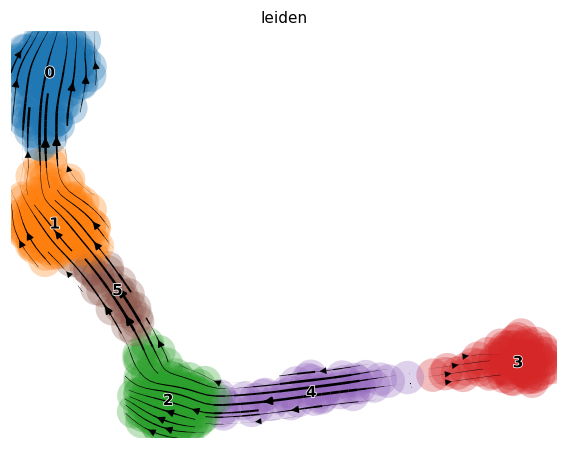

In [78]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scv.pl.velocity_embedding_stream(adata, basis='umap',color="leiden", dpi=110)

In [79]:
size_x=500
size_y=500
n_genes=300
n_cells=500
cohabiting=False
a=simulate_space(adata,how='spatial_gradient',spread=15,size_x=size_x,size_y=size_y)

Renamed 'spatial' to convention 'X_spatial' (adata.obsm).
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_spatial', embedded velocity vectors (adata.obsm)


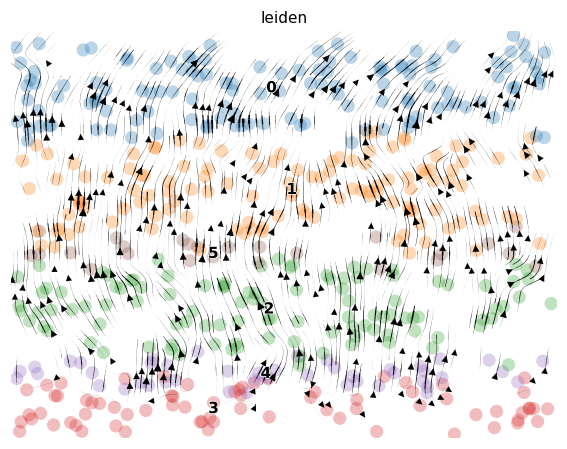

In [80]:
scv.pl.velocity_embedding_stream(a, basis='spatial',color="leiden", dpi=110,s=300, density=3)

# Velocity - nucleus -cyto

In [54]:
adata = simulation(500,n_vars=300)

In [55]:
adata

AnnData object with n_obs × n_vars = 500 × 300
    obs: 'true_t'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling'
    layers: 'unspliced', 'spliced', 'spliced_nuc', 'spliced_cyto', 'nucleic'

In [81]:
adata.layers["unspliced"]= adata.layers["nucleic"]
adata.layers["spliced"]= adata.layers["spliced_cyto"]

In [82]:
sc.pp.filter_cells(adata,min_counts = 20)
sc.pp.filter_genes(adata,min_cells = 4)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_neighbors = 20 ,n_pcs=0)
sc.tl.umap(adata, min_dist=1)
sc.tl.leiden(adata)

In [83]:
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [84]:
scv.tl.recover_dynamics(adata)

recovering dynamics (using 1/8 cores)
    finished (0:00:15) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [85]:
scv.tl.velocity(adata, mode='dynamical')

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [86]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/8 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


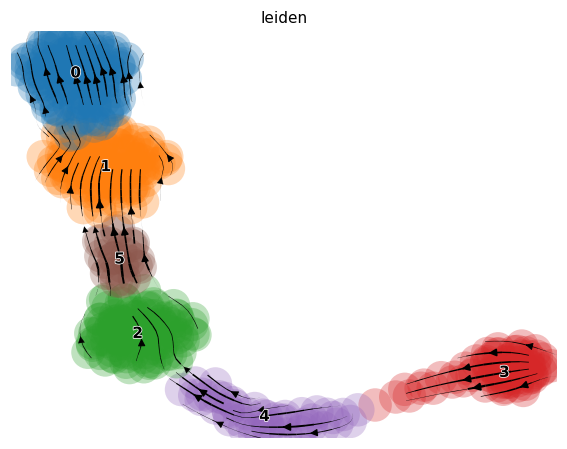

In [87]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scv.pl.velocity_embedding_stream(adata, basis='umap',color="leiden", dpi=110)

In [23]:
import random
def simulate_space(adata:'AnnData',how:str='random',size_x:str=1000,size_y:str=1000,spread:int=10):
    '''Simulate the spatial distribution of cells
    Parameters
    ----------
    adata:'AnnData object'
        Adata object including previously simulated cells 
    how:'str'
        Method to use to simulate the space.Options are:
            - 'random': assign a random position to each cell
            - 'spatial_gradient': cells are positioned forming a gradient in y according to their diff. trajectory, included in (y).
    size_x:'float':
        X dimension of the tissue space simulated 
    size_y:'float':
        Y dimension of the tissue space simulated
    spread:'int':
        If 'spatial_gradient' is considered as a method, spreads indicates how many units can the Y coordinate of a cell differ the Y position predicted from 'true_t'
        The higher this value is, the less clear the gradient will be
    Returns
    -------
    adata:'AnnData object'
        Adata object including previously simulated cells with spatial positions
    
    '''
    if how=='random':
        n_cells=adata.obs.shape[0]
        xpos=[random.uniform(0,size_x) for _ in range(n_cells)]
        ypos=[random.uniform(0,size_y) for _ in range(n_cells)]
    if how=='spatial_gradient':
        n_cells=adata.obs.shape[0]
        xpos=[random.uniform(0,size_x) for _ in range(n_cells)]
        n_cells=adata.obs.shape[0]
        relative_y=adata.obs['true_t'].div(adata.obs['true_t'].max())*size_y
        ypos=[i+random.uniform(-spread,spread) for i in relative_y]

    adata.obs['x']=xpos
    adata.obs['y']=ypos
    adata.obsm['spatial']=np.array([list(xpos),list(ypos)]).transpose()
    return adata

In [63]:
size_x=500
size_y=500
n_genes=300
n_cells=500
cohabiting=False
a=simulate_space(adata,how='spatial_gradient',spread=15,size_x=size_x,size_y=size_y)

In [64]:
adata

AnnData object with n_obs × n_vars = 500 × 300
    obs: 'true_t', 'n_counts', 'leiden', 'velocity_self_transition', 'x', 'y'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling', 'n_cells', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'velocity_umap', 'spatial'
    varm: 'PCs', 'loss'
    layers: 'unspliced', 'spliced', 'spliced_nuc', 'spliced_cyto', 'nucleic', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'
    obsp: 'distances', 'connectivities'

Renamed 'spatial' to convention 'X_spatial' (adata.obsm).
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_spatial', embedded velocity vectors (adata.obsm)


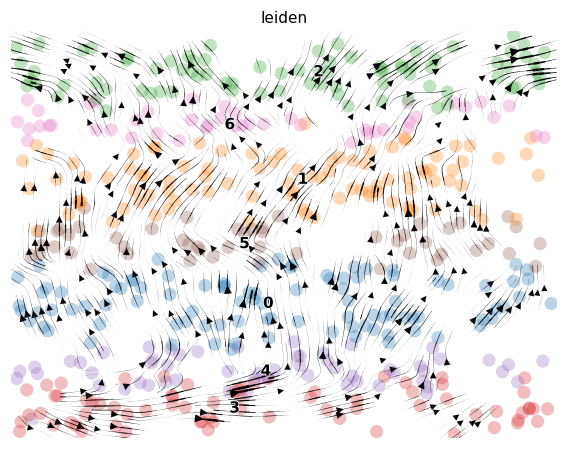

In [65]:
scv.pl.velocity_embedding_stream(a, basis='spatial',color="leiden", dpi=110,s=300,density=3)